# MAC6922 - Tópicos Avançados de Pesquisa em Cidades Inteligentes


## Script para associar acidentes aos links do simulador
- Percorre XML labeled_network.xml e preenche os links com quantidades de acidentes

### Lendo acidentes e removendo aqueles fora do mapa de São Paulo

In [1]:
import geopandas as gpd
import pandas as pd
import shapely
from shapely.ops import cascaded_union, nearest_points
import sys
import math
import matplotlib.pyplot as plt
import numpy as np
import pyproj
import os
from xml.dom.minidom import parse, parseString
from shapely.geometry import LineString, Point
from math import radians, degrees, sin, cos, asin, acos, sqrt
import xml.etree.ElementTree as ET
import itertools

# Geodesic
from functools import partial
from shapely.ops import transform

import time


In [2]:
# Reading accidents
accidents_csv = pd.read_csv('df_incidentes_2017_infra.csv', delimiter=',')
accidents_csv = accidents_csv[(accidents_csv.lat != 0) | (accidents_csv.lon != 0)]
# Removing duplicated accidents
assert len(accidents_csv) == len(accidents_csv.record_id.unique())

# Creating GeoDataFrame from lat,lon
accidents = gpd.GeoDataFrame(accidents_csv, geometry=gpd.points_from_xy(accidents_csv.lon, accidents_csv.lat))

# Copy all of the files regarding SP District to data/
# http://dados.prefeitura.sp.gov.br/dataset/af41e7c4-ae27-4bfc-9938-170151af7aee/resource/9e75c2f7-5729-4398-8a83-b4640f072b5d/download/layerdistrito.zip
sp_district = gpd.read_file('data/DEINFO_DISTRITO.shp')
sp_district.crs = '+init=epsg:29193' # SAD69

# Converts current projection to latlong using epsg codes
# http://processamentodigital.com.br/2013/07/27/lista-dos-codigos-epsg-mais-utilizados-no-brasil/
desired_proj = "+init=epsg:4326" # Latlong
sp_latlong = sp_district.to_crs(desired_proj)

# Joining all of the district polygons into a single SP polygon (SP Boundary)
sp_district_polygons = sp_latlong.geometry.to_list()
sp_boundary = gpd.GeoSeries(cascaded_union(sp_district_polygons))

# Selecting accidents within SP boundaries
accidents_within = accidents[accidents.geometry.within(sp_boundary.iloc[0])]
accidents_within.crs = '+init=epsg:4326' # Latlong

In [4]:
accidents_cycle = accidents_within[accidents_within["infra_tipo"] != '0']
accidents_cyclepath = accidents_within[accidents_within['infra_tipo'].isin(['ciclovia', 'ciclofaixa', 'ciclorrota'])]
accidents_cyclepath.shape

(118, 23)

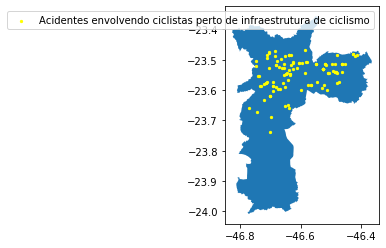

In [5]:
# Plot SP map
sp_boundary.plot()

# Plot accidents within SP boundaries
#plt.scatter(accidents_within.lon, accidents_within.lat, color='yellow', s=5, label='Acidentes no poligono de SP')

# Plot accidents within SP boundaries involving cyclists near cycling infrastructure
plt.scatter(accidents_cycle.lon, accidents_cycle.lat, color='yellow', s=5, label='Acidentes envolvendo ciclistas perto de infraestrutura de ciclismo')

plt.legend()
plt.show()

### Associando um acidente a um link

In [6]:
def read_graph(pathway):
    # Openning XML file with São Paulo's nodes and links
    tree = ET.parse(pathway)
    root = tree.getroot()

    # Reading XML links to dictionary edges
    edges = {}
    for link_xml in root.find('links').findall('link'):
        link_id = link_xml.attrib['id']
        node_from_id = link_xml.attrib['from']
        node_to_id = link_xml.attrib['to']
        edges[link_id] = (node_from_id, node_to_id)
    
    # Reading XML nodes to dictionary nodes, for plotting purposes only
    nodes = {}
    xs_mapa = []
    ys_mapa = []
    for node_xml in root.find('nodes').findall('node'):
        node_id = node_xml.attrib['id']
        x = float(node_xml.attrib['x'])
        y = float(node_xml.attrib['y'])
        nodes[node_id] = (x, y)
        xs_mapa.append(x)
        ys_mapa.append(y)
    
    return (edges, nodes, xs_mapa, ys_mapa)

In [7]:
def write_xml(accident_nearest_link, pathway_in, pathway_out):
    # Openning XML file with São Paulo's nodes and links
    tree = ET.parse(pathway_in)
    root = tree.getroot()
    
    # Create a dict with key = links id and value = 0, create XML attribute 'accidents' for every link 
    links_qt_accidents = {}
    for elem in root.find('links').findall('link'):
        links_qt_accidents[elem.attrib['id']] = 0

    # Set value = number of accidents for elements with key = link_id
    for accident_id, link_id in accident_nearest_link.items():
        links_qt_accidents[link_id] = links_qt_accidents[link_id]+1
    
    # Set number of accidents as XML attribute 'accidents'
    for elem in root.find('links').findall('link'):
        elem.set('accidents', str(links_qt_accidents[elem.attrib['id']]))
        #if links_qt_accidents[elem.attrib['id']] != 0:
            #print('Set link_id=', elem.attrib['id'], ' as ', links_qt_accidents[elem.attrib['id']])
    
    # Writing accidents frequencies to XML links
    tree.write(pathway_out)

Link mais próximo por distância de ponto a reta (distância de acidentes a links), utilizando o método 'distance' de objetos da biblioteca Shapely:

In [8]:
# Nearest link search by distance from line to point
def nearest_link(accident, edges, nodes):
    
    nearest_link = None
    min_distance = math.inf
    
    lon_accident = accident[1][9]
    lat_accident = accident[1][8]
    point_accident = Point(lon_accident, lat_accident)
    
    # Calculate execution time in seconds as a float
    start_time = time.time()
    
    # Iterate over every (link_id, (node_to, node_from))
    for link_id, nodes_tuple in edges.items():
        node_from_id = nodes_tuple[0]
        point_from = Point(nodes[node_from_id])
        
        node_to_id = nodes_tuple[1]
        point_to = Point(nodes[node_to_id])

        link = LineString([point_from, point_to])
        
        distance = link.distance(point_accident)
        
        # ~~ Refactoring the above code in one line ~~
        #distance = LineString([Point(nodes[nodes_tuple[0]]), Point(nodes[nodes_tuple[1]])]).distance(point_accident)
        
        if distance < min_distance:
            nearest_link = link_id
            min_distance = distance
        
    # Print execution time in seconds
    end_time = time.time()
    print('Execution time: ', "{:^2f}s".format(end_time-start_time))
            
    return nearest_link

Associando acidentes a links:

In [ ]:
print('Iniciando processamento dos links')

# Read graph
pathway_in = 'labeled_network.xml'
edges, nodes, xs_mapa, ys_mapa = read_graph(pathway_in)

# Trimmind nodes for tests
NODES_NUMBER = 100
trimmed_nodes = dict(itertools.islice(nodes.items(),NODES_NUMBER))

print('Grafo lido')

#nearest_list = {}
accident_nearest_link = {}
for accident in accidents_cyclepath.iterrows():
    # Find nearest link to accident
    nearest_link_id = nearest_link(accident, edges, nodes)
    
    # Add nearest link to dict 'nearest_list', for plotting purposes only
    #node_from_x = nodes[str(edges[str(nearest_link_id)][0])][0]
    #node_from_y = nodes[str(edges[str(nearest_link_id)][0])][1]
    #node_to_x = nodes[str(edges[str(nearest_link_id)][1])][0]
    #node_to_y = nodes[str(edges[str(nearest_link_id)][1])][1]
    #nearest_list[nearest_link_id] = [Point(node_from_x, node_from_y), Point(node_to_x, node_to_y)]
    
    # Add nearest link found to dict with key = accident_id, value = nearest_link_id
    accident_id = accident[1][2]
    accident_nearest_link[accident_id] = nearest_link_id
    
    #print('Acidente: ', accident[1][8], accident[1][9], ' Link mais proximo: ', nearest_link_id)
    
pathway_out = 'newitems.xml'
write_xml(accident_nearest_link, pathway_in, pathway_out)
prettify(pathway_out)

Iniciando processamento dos links
Grafo lido
Execution time:  9.501518s
Execution time:  9.395846s
Execution time:  9.511088s
Execution time:  9.514570s
Execution time:  9.469311s
Execution time:  9.439995s
Execution time:  9.641234s
Execution time:  9.452276s
Execution time:  9.497284s
Execution time:  9.458501s
Execution time:  9.555601s
Execution time:  9.723471s
Execution time:  9.430160s
Execution time:  9.442013s
Execution time:  9.421123s
Execution time:  9.433300s
Execution time:  9.564840s
Execution time:  9.914441s
Execution time:  9.447638s
Execution time:  11.038769s
Execution time:  9.791164s
Execution time:  9.424952s
Execution time:  9.702839s
Execution time:  9.644271s
Execution time:  9.513494s
Execution time:  9.646231s
Execution time:  9.513108s
Execution time:  9.865855s
Execution time:  10.687140s
Execution time:  9.856097s
Execution time:  9.593320s
Execution time:  9.908768s
Execution time:  9.677848s
Execution time:  9.487127s
Execution time:  9.762074s
Executio

Verificando graficamente se os acidentes realmente se localizam próximos aos links associados acima:

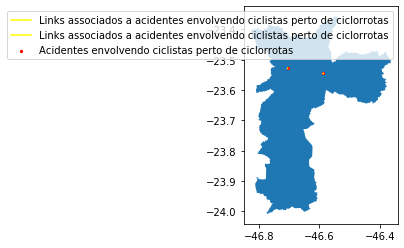

In [45]:
# Plot SP map
sp_boundary.plot()

# Iterate over every link in nearest_list
for link_id, link_points in nearest_list.items():
    
    node_from, node_to = link_points
    #print('Node from: ', node_from)
    #print('Node to: ', node_to)
    x_values = [node_from.x, node_to.x]
    y_values = [node_from.y, node_to.y]
    
    # Plot links near accidents within SP boundaries involving cyclists near cyclepath
    plt.plot(x_values, y_values, color='yellow', label='Links associados a acidentes envolvendo ciclistas perto de ciclorrotas')
# Plot accidents within SP boundaries involving cyclists near cyclepath
plt.scatter(accidents_cyclepath.lon, accidents_cyclepath.lat, color='red', s=5, label='Acidentes envolvendo ciclistas perto de ciclorrotas')

plt.legend()
plt.show()

### Escrevendo XML

### Outros

Função que transforma o XML de uma linha só (que o Gedit não consegue abrir) para um XML indentado 

In [40]:
# Prettify
def prettify(pathway):
    dom1 = parse(pathway)
    text_file = open(pathway, 'w')
    text_file.write(dom1.toprettyxml(indent=' '*4))
    text_file.close()

Visualizando a distribuição de comprimentos do links

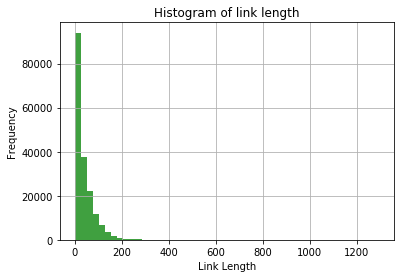

In [77]:
def calc_distance_meters(p1, p2):
    lon1, lat1, lon2, lat2 = map(radians, [p1.y, p1.x, p2.y, p2.x])
    try:
        return 6371000 * (
            acos(sin(lat1) * sin(lat2) + cos(lat1) * cos(lat2) * cos(lon1 - lon2))
        )
    except ValueError:
        # In some cases, it returns an error because of very small distances
        return 1

def calc_distance(x1, y1, x2, y2):
    return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

# Read graph
edges, nodes, xs_mapa, ys_mapa = read_graph('labeled_network.xml')

# Trimmind edges for tests
#EDGES_NUMBER = 100
#edges = dict(itertools.islice(edges.items(),EDGES_NUMBER))

distance = {}
# Iterate over every (link_id, (node_to, node_from))
for link_id, nodes_tuple in edges.items(): 
    node_from_id = nodes_tuple[0]
    point_from = Point(nodes[node_from_id])

    node_to_id = nodes_tuple[1]
    point_to = Point(nodes[node_to_id])
    
    distance[link_id] = calc_distance_meters(point_from, point_to)
    #distance[link_id]=point_from.distance(point_to)

# the histogram of the data
plt.hist(distance.values(), 50, facecolor='g', alpha=0.75)

plt.xlabel('Link Length')
plt.ylabel('Frequency')
plt.title('Histogram of link length')
#plt.xlim(0, 400)
plt.grid(True)
plt.show()

Link mais próximo por Spacial Join, criando buffers para acidentes e links:

In [9]:
def geodesic_point_buffer(lat, lon, dist, id = None):
    proj_wgs84 = pyproj.Proj(init='epsg:4326')
    if id != None: 
        print(id, lat, lon)
    aeqd_proj = '+proj=aeqd +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0'
    project = partial(
        pyproj.transform,
        pyproj.Proj(aeqd_proj.format(lat=lat, lon=lon)),proj_wgs84)
    buf = Point(0, 0).buffer(dist)
    return transform(project, buf)


def nearest_link_buffer(accident, nodes):
    
    # Dictionary nodes to node DataFrame nodes_df
    nodes_df = pd.DataFrame.from_dict(nodes, orient='index')
    nodes_df['id'] = nodes_df.index
    nodes_df.columns = ['lon', 'lat', 'id']

    # Node buffers
    #WITDH_LINK_BUFFER = 2.5
    WITDH_LINK_BUFFER = 200 # Value based on the analysis the distribution of likn lengths, with all(?) < 400
    nodes_buffers = nodes_df.apply(lambda row: geodesic_point_buffer(row.lat, row.lon, WITDH_LINK_BUFFER, id = None), axis=1)
    # Node buffers to GeoDataFrame
    crs = {'init': 'epsg:4326'}
    node_buffers_gdf = gpd.GeoDataFrame(data=nodes_df.id, geometry=nodes_buffers, crs=crs)

    # Tuple accident to DataFrame
    accident =  accident[1].to_frame().transpose()
    
    # Using accident
    #geometry = zip(accident.lon,accident.lat)
    geometry = [Point(accident.lon, accident.lat)]
    point_accident_gdf = gpd.GeoDataFrame(data=accident.record_id, geometry=geometry, crs=crs)
    
    # Intercects nodes_buffer and point_accident // op = {‘intersects’, ‘contains’, ‘within’}
    #sjoin = gpd.sjoin(node_buffers_gdf, point_accident_gdf, op='contains') 
    sjoin = gpd.sjoin(node_buffers_gdf, point_accident_gdf, op='contains')
    
    # Using accident buffer
    #RADIUS_ACCIDENT = 2.5
    #point_accident_buffer = geodesic_point_buffer(
    #    accident.lat, accident.lon, RADIUS_ACCIDENT, id = None)
    
    #point_accident_buffer_gdf = gpd.GeoDataFrame()
    # Extract the point values that define the perimeter of the polygon
    #x, y = point_accident_buffer.exterior.coords.xy
    #geometry = [Point(xy) for xy in zip(x,y)]
    
    #point_accident_buffer_gdf = gpd.GeoDataFrame(
    #    data=accident.record_id, geometry= geometry,crs=crs)
    
    # Intercects nodes_buffer and point_accident_buffer // op = {‘intersects’, ‘contains’, ‘within’}
    #sjoin = gpd.sjoin(node_buffers_gdf, point_accident_buffer_gdf, op='intersects') 
    
    print(sjoin.head())
    return None

Link mais próximo pela função nearest_points (da biblioteca shapely.ops), reduzindo os links ao seu ponto médio

In [143]:
def calc_mid_points(edges, nodes):
    
    mid_points_df = pd.DataFrame(columns=['id', 'geometry'])
    
    
    mid_points_dict = {} # Dictionary to pass to panda's dataframe
    index = 0 # Counter to use to add entries to "mid_points_dict"
    
    # Calculate execution time in seconds as a float
    start_time = time.time()
    
    # Iterate over every (link_id, (node_to, node_from))
    for link_id, nodes_tuple in edges.items():
        #node_from_id = nodes_tuple[0]
        #point_from = Point(nodes[node_from_id])
        
        #node_to_id = nodes_tuple[1]
        #point_to = Point(nodes[node_to_id])
        
        #mid = Point((point_from.x+point_to.x)/2, (point_from.y+point_to.y)/2)
        #mid_points_df = mid_points_df.append({'id': link_id, 'geometry': mid_point}, ignore_index=True)
        
        # ~~ Refactoring the above code in one line ~~

        mid_point = LineString([Point(nodes[nodes_tuple[0]]), Point(nodes[nodes_tuple[1]])]).interpolate(0.5, normalized = True)
        #mid_points_df = mid_points_df.append({'id': link_id, 'geometry': mid_point}, ignore_index=True)
        
        # Add a dictionary entry to the mid_points_dict
        mid_points_dict[index] = {'link_id': link_id, 'geometry': mid_point}
        # Increment the "index" counter
        index = index + 1
    
    # Print execution time in seconds
    end_time = time.time()
    print('Execution time: ', "{:^2f}s".format(end_time-start_time))
    
    # create the dataframe using 'from_dict'
    # important to set the 'orient' parameter to "index" to make the keys as rows
    mid_points_df = pd.DataFrame.from_dict(mid_points_dict, "index")    
    mid_points_gdf = gpd.GeoDataFrame(mid_points_df, geometry=mid_points_df.geometry)
    return mid_points_gdf

def nearest_link_mid_points(accident, mid_points_gdf):
    
    # Calculate execution time in seconds as a float
    start_time = time.time()
    
    # Tuple accident to DataFrame 
    accident =  accident[1].to_frame().transpose()
    
    # LatLon to Point
    point_accident = Point(accident.lon, accident.lat)
    
    # Unary union of the mid_points geometries
    mid_points_union = mid_points_gdf.geometry.unary_union
    
    # Find the nearest points between (Point from LatLon, unary union of the mid_points geometries)
    nearest = nearest_points(point_accident, mid_points_union)[1]
    
    # Retrieves the link_id of the nearest mid_point found 
    #nearest_id = mid_points.loc[mid_points.geometry == nearest]
    
    # Retrieves the link_id of the nearest mid_point found
    # Problem: returning more than one nearest_id
    nearest_id = mid_points_gdf[mid_points_gdf['geometry'] == nearest] #.link_id.get_values()[0]
    
    # Print execution time in seconds
    end_time = time.time()
    print('Execution time: ', "{:^2f}s".format(end_time-start_time))
    
    return nearest_id

### Outros (códigos relacionados do Victor, Leo e Marcelo)

In [ ]:
# Verifica quais links tem cyclelane ou cicleway

def process_link(link_xml):
    link_id = link_xml.attrib['id']
    node_id_from = link_xml.attrib['from']
    node_id_to = link_xml.attrib['to']
    x_from, y_from = this.nodes[node_id_from]
    x_to, y_to = this.nodes[node_id_to]
    point_from = Point(x_from, y_from)
    point_to = Point(x_to, y_to)
    #
    # para ciclofaixa
    dist1 = distancia_para_ciclofaixa(point_from)
    dist2 = distancia_para_ciclofaixa(point_to)    
    if dist1 < this.LIMIAR and dist2 < this.LIMIAR:
        print('Link %s tem ciclofaixa' % link_id)
        link_xml.attrib['cyclelane'] = "true" # marca link como ciclofaixa
        link_xml.attrib['cycleway'] = "false" # marca que não é ciclovia, pois dados do geosampa prevalecem sobre os dados do streetmaps
        this.xs_ciclofaixas.append(x_to)
        this.ys_ciclofaixas.append(y_to)
    else:
        link_xml.attrib['cyclelane'] = "false" # marca link como ciclofaixa
    #
    # para ciclovia
    dist1 = distancia_para_ciclovia(point_from)
    dist2 = distancia_para_ciclovia(point_to)    
    if dist1 < this.LIMIAR and dist2 < this.LIMIAR:
        print('Link %s tem ciclovia' % link_id)
        link_xml.attrib['cycleway'] = "true" # marca link como ciclofaixa
        this.xs_ciclovias.append(x_to)
        this.ys_ciclovias.append(y_to)
    else:
        # se streemap falou que tinha ciclovia, mantemos como ciclovia,
        # considerando o streetmaps como informação complementar
        pass


In [ ]:
def distancia_para_ciclofaixa(point):
    nearst_point = shapely.ops.nearest_points(point, this.pts_ciclofaixas_geosampa)[1]
    return distancia_entre_pontos_latlong_em_metros(point, nearst_point)


In [ ]:
def distancia(x1, y1, x2, y2):
    return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

In [ ]:
def distancia_entre_pontos_latlong_em_metros(p1, p2):
    lon1, lat1, lon2, lat2 = map(radians, [p1.y, p1.x, p2.y, p2.x])
    try:
        return 6371000 * (
            acos(sin(lat1) * sin(lat2) + cos(lat1) * cos(lat2) * cos(lon1 - lon2))
        )
    except ValueError:
        # Em alguns casos, dá um erro por conta da distância muito pequena
        return 1

In [16]:
xs_ciclovias_geosampa = []
ys_ciclovias_geosampa = []
xs_ciclofaixas_geosampa = []
ys_ciclofaixas_geosampa = []
xs_accidents = []
ys_accidents = []

# Read data from cycle infrastructure from GeoSampa
gdf = gpd.read_file('SAD69-96_SHP_redecicloviaria/SAD69-96_SHP_redecicloviaria.shp') 
gdf.crs = '+init=epsg:29193' # GeoSampa spatial reference projection

desired_proj="+init=epsg:4326" # LatLon projection
gdf = gdf.to_crs(desired_proj) # Convert projection

cyclelanes = gdf[gdf['rc_descric'] == 'CICLOFAIXA']
cyclelanes_points = cyclelanes.geometry.unary_union

cicloway = gdf[gdf['rc_descric'] == 'CICLOVIA']
cicloway_points = cicloway.geometry.unary_union

# Percorre pontos do geosampa só pra adicionar
# os pontos em xs_ciclofaixas e ys_ciclofaixas 
# pra poder printar o traçado original (geosampa) das ciclofaixas
for infra_type, geometry in gdf[['rc_descric', 'geometry']].values: 

    if infra_type == 'CICLOFAIXA':
        if type(geometry) == shapely.geometry.linestring.LineString:
            for coords in geometry.coords:
                x_geosampa, y_geosampa = list(coords)
                xs_ciclofaixas_geosampa.append(x_geosampa)
                ys_ciclofaixas_geosampa.append(y_geosampa)
        if type(geometry) == shapely.geometry.multilinestring.MultiLineString:
            for via in geometry:
                for coords in via.coords:
                    x_geosampa, y_geosampa = list(coords)
                    xs_ciclofaixas_geosampa.append(x_geosampa)
                    ys_ciclofaixas_geosampa.append(y_geosampa)

    if infra_type == 'CICLOVIA':
        if type(geometry) == shapely.geometry.linestring.LineString:
            for coords in geometry.coords:
                x_geosampa, y_geosampa = list(coords)
                xs_ciclovias_geosampa.append(x_geosampa)
                ys_ciclovias_geosampa.append(y_geosampa)
        if type(geometry) == shapely.geometry.multilinestring.MultiLineString:
            for via in geometry:
                for coords in via.coords:
                    x_geosampa, y_geosampa = list(coords)
                    xs_ciclovias_geosampa.append(x_geosampa)
                    ys_ciclovias_geosampa.append(y_geosampa)

# Read graph to plot
edges, nodes, xs_mapa, ys_mapa = read_graph('labeled_network.xml')                    

# Plot graph
plt.scatter(xs_mapa, ys_mapa, color='blue', s=1, label='pontos do mapa')
plt.scatter(xs_ciclofaixas_geosampa, ys_ciclofaixas_geosampa, color='red', s=20, label='ciclofaixas no geosampa')
plt.scatter(xs_ciclovias_geosampa, ys_ciclovias_geosampa, color='orange', s=20, label='ciclovias no geosampa')
plt.scatter(accidents_csv.lon, accidents_csv.lat, color='yellow', s=20, label='acidentes próximos de infra cicloviária')
plt.legend()
plt.show()